$ \textbf{Aluna:}$ Alessandra da Silva Dias Malizia   
$ \textbf{Data:}$ 11/06/2025

# Lista Prática 2

In [86]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preparação dos dados

In [34]:
data_base = pd.read_csv('C:\\Users\\aless\\Desktop\\Codes\\Modelos estruturais\\dados_precipitacao.csv')
data_base.dtypes

id_estacao             object
estacao                object
data_fundacao          object
ano                     int64
mes                     int64
precipitacao_total    float64
dtype: object

In [ ]:
data_base['data'] = pd.to_datetime(data_base.apply(lambda row: '{}-{:02}-01'.format(row.ano, row.mes), axis=1))
data = data_base.pivot_table(index='data', columns='estacao', values='precipitacao_total')

In [42]:
estacoes = data.apply(lambda col: col.dropna().index[0]).sort_values().head(5).index
data.apply(lambda col: col.dropna().index[0]).sort_values().head(10)

estacao
Manaus                         2000-05-01
Brasilia                       2000-05-01
Seropedica-Ecologia Agricola   2000-05-01
Porto Alegre                   2000-09-01
Salvador                       2000-10-01
Morrinhos                      2001-05-01
Goiania                        2001-05-01
Bauru                          2001-08-01
Campo Grande                   2001-09-01
Tres Lagoas                    2001-09-01
dtype: datetime64[ns]

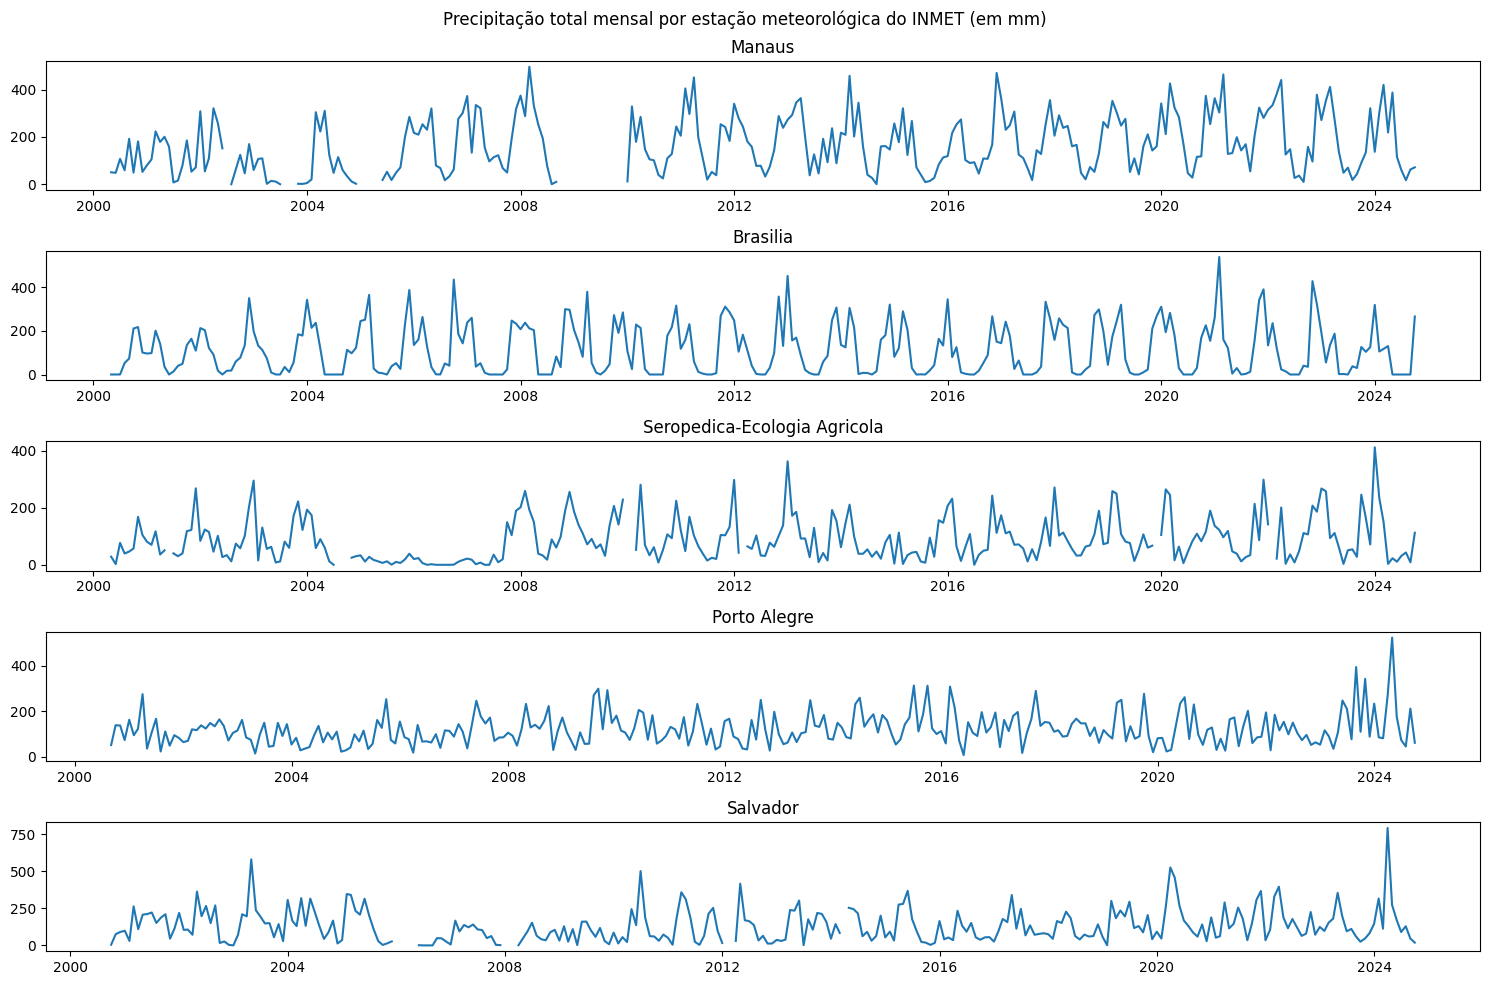

In [57]:
fig, ax = plt.subplots(5, figsize=(15,10))

for i in range(5):
    ax[i].plot(data[estacoes].iloc[:,i])
    ax[i].set_title(estacoes[i])
    # ax[i].grid()


fig.suptitle('Precipitação total mensal por estação meteorológica do INMET (em mm)')
fig.tight_layout()
plt.show()

In [59]:
series = data[['Brasilia']]

# Questão 1

## a)
- Gráfico da série temporal
- FAC
- FAC da 1 diferença
- FAC da 1 diferença da diferença sazonal

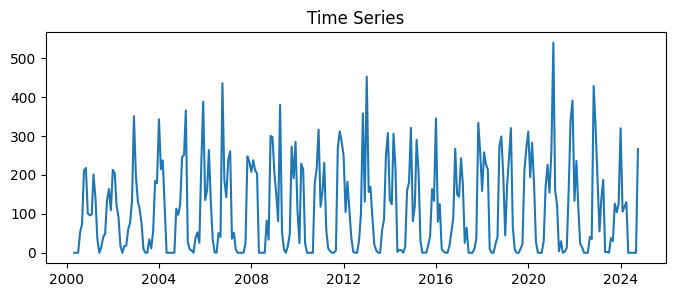

In [60]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(series)
ax.set_title('Time Series')
plt.show()

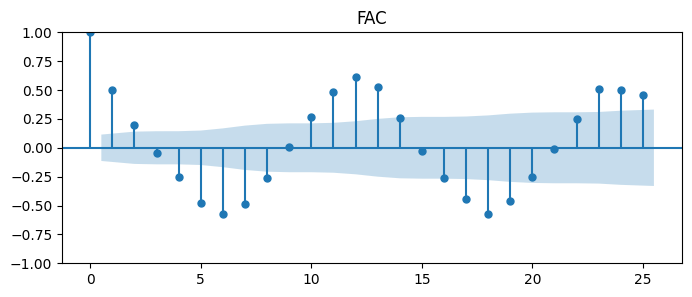

In [63]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series, ax=ax, title='FAC')

plt.show()

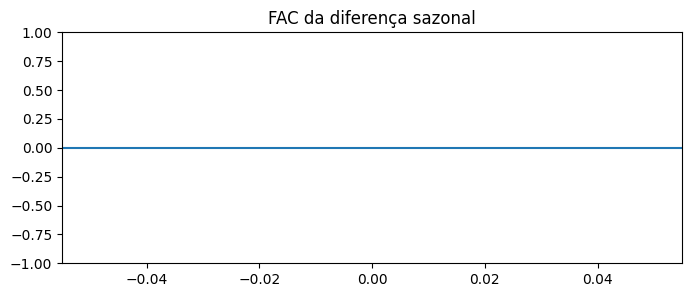

In [72]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series.diff(12), ax=ax, title='FAC da diferença sazonal')

plt.show()

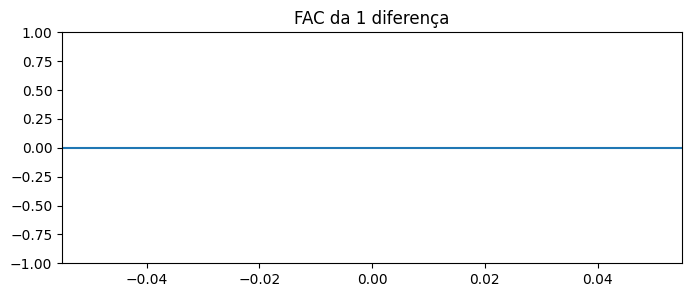

In [64]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series.diff(), ax=ax, title='FAC da 1 diferença')

plt.show()

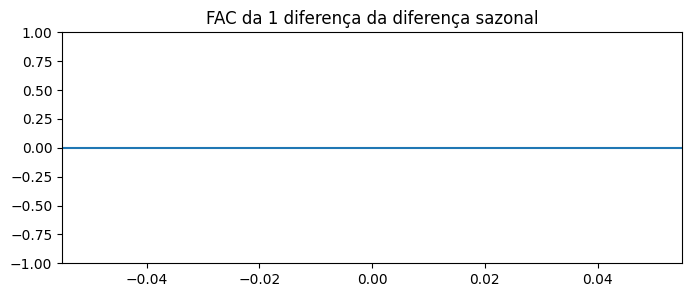

In [73]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series.diff(12).diff(), ax=ax, title='FAC da 1 diferença da diferença sazonal')

plt.show()

## b)
- Boxplot da série original
- Boxplot da 1 diferença

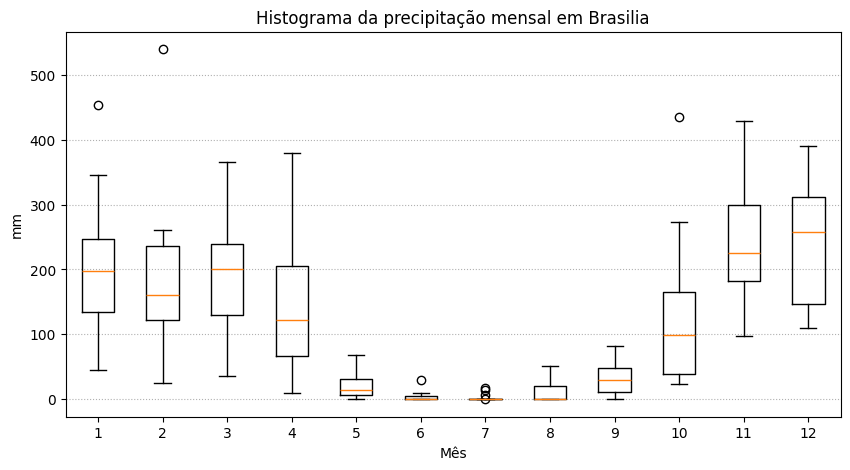

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
plot_data = (series
    .pivot_table(columns=series.index.month, index=series.index.year, values='Brasilia')
    .dropna()
)
ax.boxplot(plot_data)
ax.set_ylabel('mm')
ax.set_xlabel('Mês')
ax.grid(axis='y', linestyle=':')
ax.set_title('Histograma da precipitação mensal em Brasilia')
plt.show()

## c) Teste de sazonalidade

In [93]:
acorr_ljungbox(series['Brasilia'], lags=[15])

,lb_stat,lb_pvalue
15,682.041703,1.246815e-135


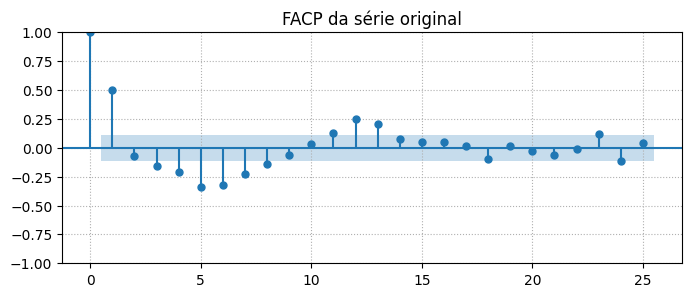

In [94]:
fig, ax = plt.subplots(figsize=(8,3))

plot_pacf(series, ax=ax, title='FACP da série original')
ax.grid(axis='both', linestyle=':')
plt.show()

## d) Estimação do modelo